In [1]:
import numpy as np
import sklearn.linear_model as linear
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [8]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406022,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
406023,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
406024,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
406025,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Cleaning data and Sorting to Input and Target Arrays

In [21]:
x = [] # input (attributes)
y = [] # output (targets)

x = finalFeatures.iloc[:, 1:57].values
y = finalFeatures.iloc[:, 57].values
print(x)
x = MinMaxScaler().fit_transform(x)

[[38.1204 38.1204 38.1204 ...  0.      0.      6.9586]
 [37.6965 38.1204 38.0819 ...  0.      0.      2.4331]
 [38.1204 38.1204 38.1204 ...  0.      0.      4.4543]
 ...
 [32.2    36.8    34.1643 ...  2.9569  1.7434  0.601 ]
 [38.1204 38.1204 38.1204 ... 13.1009  3.247   2.3838]
 [38.1204 38.1204 38.1204 ...  0.      0.      6.9586]]


#### Setting up Models for Neural Network

In [56]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x, y, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(x, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [76]:
class NNModel(MoonModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 56, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(56, 1, bias=True)
        self.act2 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        return res

    def forward(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        return res


#### Applying Logistic Regression and Neural Network Model

In [77]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


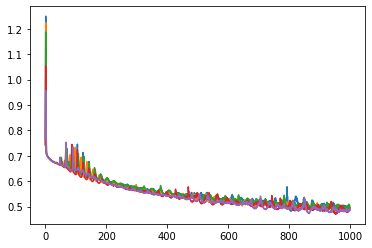

In [91]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(x)

f1_lr = []
f1_nn = []

def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))

    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    nn1 = NNModel()
    nn1.to(device)

    curve = nn1.fit(X_train, y_train, lr=0.008, lam=0.01)
    plot_loss(curve)
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))

#### Comparing Statistical Results for the Models

In [92]:
print("Logistic Regression Model Mean: ", np.mean(f1_lr))
print("Logistic Regression Model Standard Deviation: ", np.std(f1_lr))

Logistic Regression Model Mean:  0.942722935632837
Logistic Regression Model Standard Deviation:  0.00041161458318296777


In [93]:
print("Neural Network Model Mean: ", np.mean(f1_nn))
print("Neural Network Model Standard Deviation: ", np.std(f1_nn))

Neural Network Model Mean:  0.7506917713100834
Neural Network Model Standard Deviation:  0.07229097137020074


In [94]:
print("T-Test comparing the Logistic Regression and the Neural Network Models: ")
print(stats.ttest_rel(f1_lr, f1_nn))

T-Test comparing the Logistic Regression and the Neural Network Models: 
Ttest_relResult(statistic=5.310867321637168, pvalue=0.006042663031191551)


Using a significance level of 0.05, we see that the difference between logistic regression
and neural network are not statistically significant.

#### Intermediary Workings of the Neural Network

In [ ]:
X_transformed = th.tensor(x, dtype=th.float32)
representations = nn1.get_intermediary(X_transformed)
representations = representations.detach().numpy()

In [ ]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,0], representations[:,1], c=colors)